In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.show()
plt.rcParams["figure.figsize"] = [16, 9]

In [3]:
pair = 'ETHUSDC'

CALIBRATION ON DATA FROM MAY 24

In [ ]:
df_05 = pd.read_csv('../data/'+pair+'/'+pair+'-1m-2024-05.csv')
df_05.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_05.set_index('time', inplace=True)
df_05.index = pd.to_datetime(df_05.index, unit='ms')
df_05

,open,high,low,close,s1,s2,s3,s4,s5,s6,s7
time,,,,,,,,,,,
2024-05-01 00:01:00,3013.59,3015.80,3013.57,3015.05,2.0334,1714521719999,6130.720368,14,1.9171,5780.182425,0
2024-05-01 00:02:00,3014.66,3014.66,3009.54,3010.53,8.8738,1714521779999,26718.606199,38,3.6059,10855.170061,0
2024-05-01 00:03:00,3010.18,3011.60,3010.18,3011.60,0.9529,1714521839999,2869.458775,5,0.9260,2788.447004,0
2024-05-01 00:04:00,3011.59,3012.40,3010.70,3011.20,1.9819,1714521899999,5968.593744,11,0.2583,777.771880,0
2024-05-01 00:05:00,3010.61,3014.56,3010.61,3013.80,2.5970,1714521959999,7826.767471,20,2.0805,6270.041302,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 23:55:00,3761.58,3762.15,3759.51,3761.62,11.9287,1717199759999,44862.474338,39,10.1222,38067.915847,0
2024-05-31 23:56:00,3762.38,3762.38,3761.81,3761.81,0.4281,1717199819999,1610.624262,2,0.0888,334.048728,0
2024-05-31 23:57:00,3761.98,3762.51,3761.98,3762.40,0.7498,1717199879999,2820.857407,7,0.5385,2025.862287,0


In [5]:
df_may = df_05[['close']].copy()
df_may

,close
time,
2024-05-01 00:01:00,3015.05
2024-05-01 00:02:00,3010.53
2024-05-01 00:03:00,3011.60
2024-05-01 00:04:00,3011.20
2024-05-01 00:05:00,3013.80
...,...
2024-05-31 23:55:00,3761.62
2024-05-31 23:56:00,3761.81
2024-05-31 23:57:00,3762.40


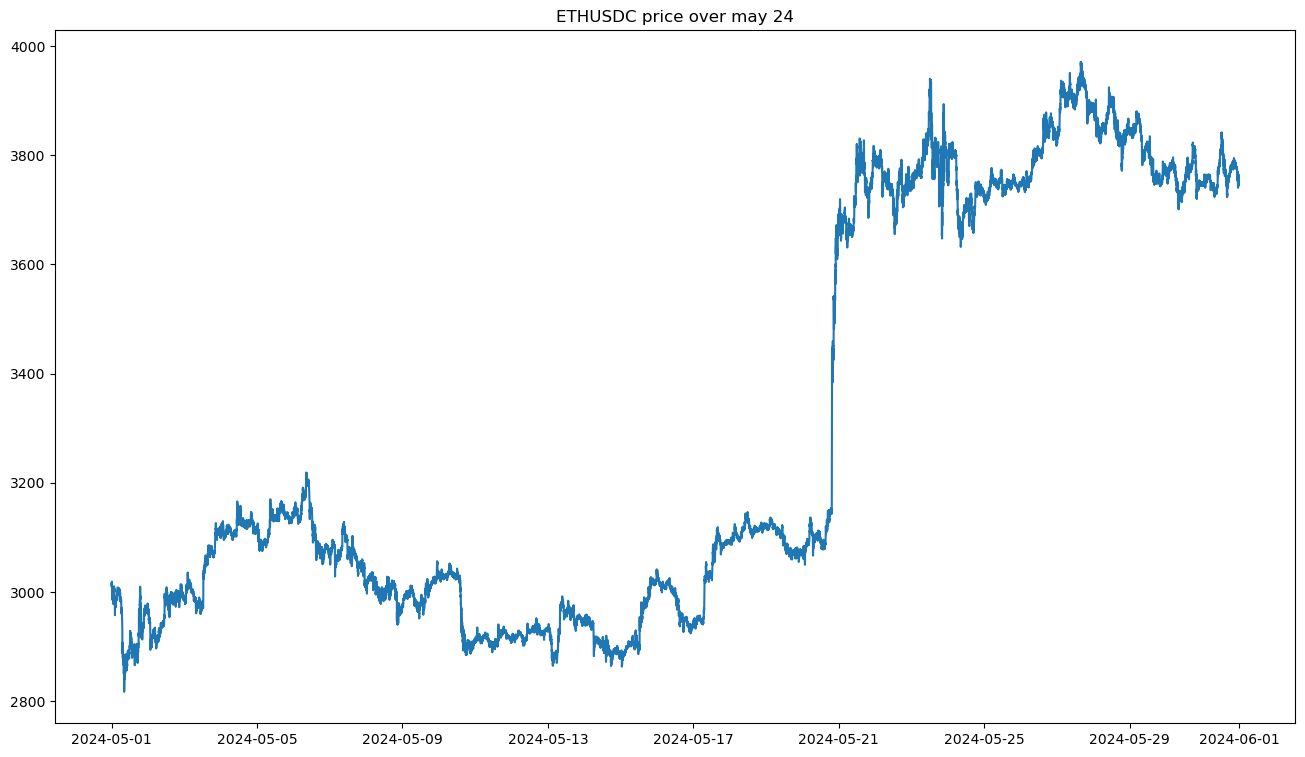

In [6]:
plt.plot(df_may.index.values, df_may['close'].values)
plt.title(pair+' price over may 24')
plt.show()

STANDARD GBM

In [7]:
df_may['log_returns'] = np.log(df_may['close'] / df_may['close'].shift(1))

trading_minutes_per_year = 365 * 24 * 60

log_return_mean = df_may['log_returns'].mean()

mu = log_return_mean * trading_minutes_per_year

log_return_variance = df_may['log_returns'].var()

vol = np.sqrt(log_return_variance * trading_minutes_per_year)

print('mu=',mu)
print('mu_daily=',mu/365)
print('sigma=',vol)
print('sigma_daily=',vol/np.sqrt(365))

mu= 2.5954406908574073
mu_daily= 0.007110796413307965
sigma= 0.6260775661260336
sigma_daily= 0.03277039755074224


HESTON MODEL

In [8]:
window_size = 60  # 1 hour window
df_may['rolling_std'] = df_may['log_returns'].rolling(window=window_size).std()
df_may['annualized_volatility'] = df_may['rolling_std'] * np.sqrt(trading_minutes_per_year)

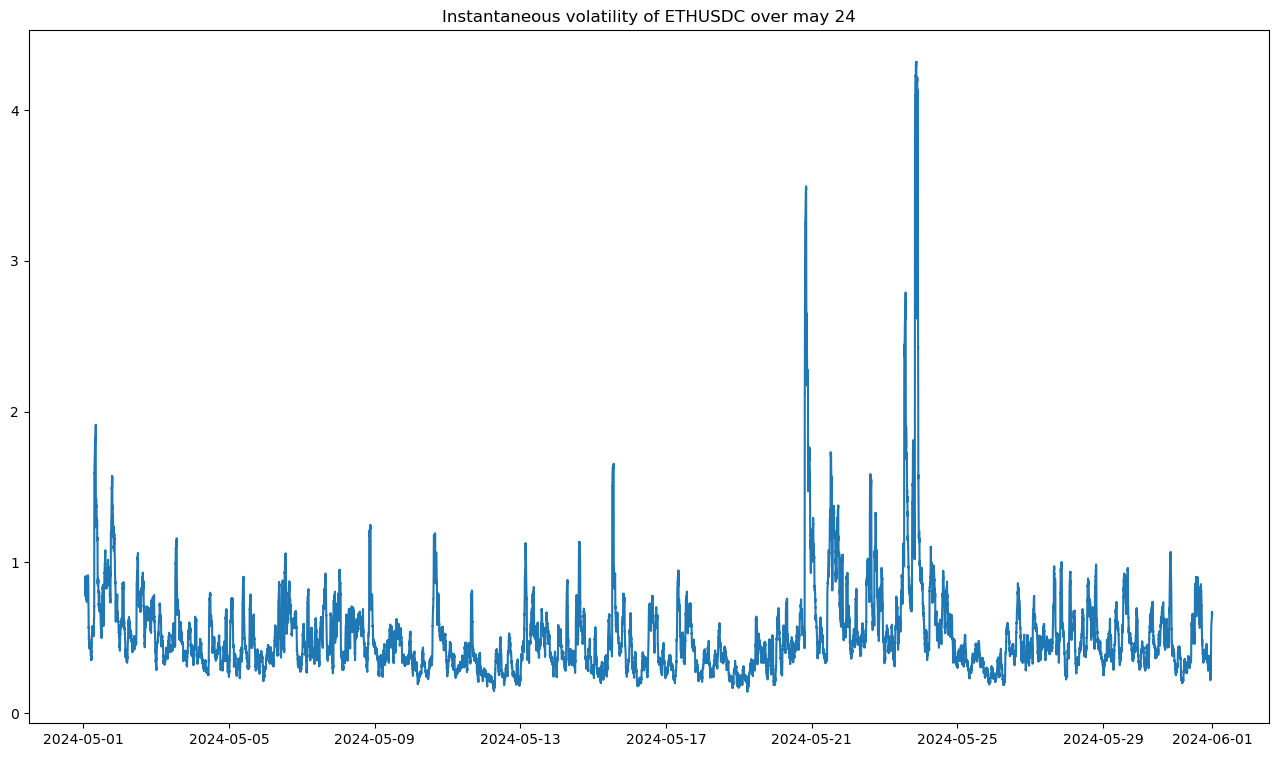

In [9]:
plt.plot(df_may.index.values, df_may['annualized_volatility'].values)
plt.title('Instantaneous volatility of '+pair+' over may 24')
plt.show()

In [10]:
from scipy.optimize import minimize

def heston_log_likelihood(params, variances, dt):
    kappa, theta, sigma = params
    log_likelihood = 0
    
    for t in range(1, len(variances)):
        vt = variances[t-1]
        vt_next = variances[t]
        mean = vt + kappa * (theta - vt) * dt
        variance = sigma**2 * vt * dt
        
        log_likelihood += -0.5 * np.log(2 * np.pi * variance) - (vt_next - mean)**2 / (2 * variance)
    
    return -log_likelihood  

initial_params = [100., 1e-12, 0.02]

dt = 1./trading_minutes_per_year

variances = df_may['annualized_volatility']**2

result = minimize(heston_log_likelihood, initial_params, args=(variances, dt), method='Powell')

kappa_opt, theta_opt, sigma_opt = result.x

print(f"Estimated kappa: {kappa_opt}")
print(f"Estimated theta: {theta_opt}")
print(f"Estimated sigma: {sigma_opt}")

Estimated kappa: 102.58792896154584
Estimated theta: 2.587928961546842
Estimated sigma: 2.607928961545842


CALIBRATION ON DATA FROM JUNE 24


In [ ]:
df_06 = pd.read_csv('../data/'+pair+'/'+pair+'-1m-2024-06.csv')
df_06.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_06.set_index('time', inplace=True)
df_06.index = pd.to_datetime(df_06.index, unit='ms')
df_06

,open,high,low,close,s1,s2,s3,s4,s5,s6,s7
time,,,,,,,,,,,
2024-06-01 00:01:00,3762.43,3762.43,3762.43,3762.43,0.0000,1717200119999,0.000000,0,0.0000,0.000000,0
2024-06-01 00:02:00,3759.41,3761.41,3759.41,3760.91,0.7600,1717200179999,2858.490700,6,0.0954,358.657614,0
2024-06-01 00:03:00,3760.80,3764.64,3759.60,3762.20,13.2412,1717200239999,49827.831455,61,10.2637,38625.181622,0
2024-06-01 00:04:00,3761.73,3765.53,3761.73,3762.96,38.8119,1717200299999,146083.076078,53,36.3503,136819.211605,0
2024-06-01 00:05:00,3762.60,3763.80,3762.60,3763.27,3.4958,1717200359999,13156.142840,16,1.9712,7418.032718,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 23:55:00,3436.62,3436.62,3436.62,3436.62,0.0961,1719791759999,330.259182,2,0.0961,330.259182,0
2024-06-30 23:56:00,3437.09,3437.09,3434.80,3434.80,2.9474,1719791819999,10125.844309,30,0.0888,305.213592,0
2024-06-30 23:57:00,3435.16,3435.38,3435.16,3435.31,0.1892,1719791879999,649.948144,4,0.0888,305.042208,0


In [12]:
df_june = df_06[['close']].copy()
df_june

,close
time,
2024-06-01 00:01:00,3762.43
2024-06-01 00:02:00,3760.91
2024-06-01 00:03:00,3762.20
2024-06-01 00:04:00,3762.96
2024-06-01 00:05:00,3763.27
...,...
2024-06-30 23:55:00,3436.62
2024-06-30 23:56:00,3434.80
2024-06-30 23:57:00,3435.31


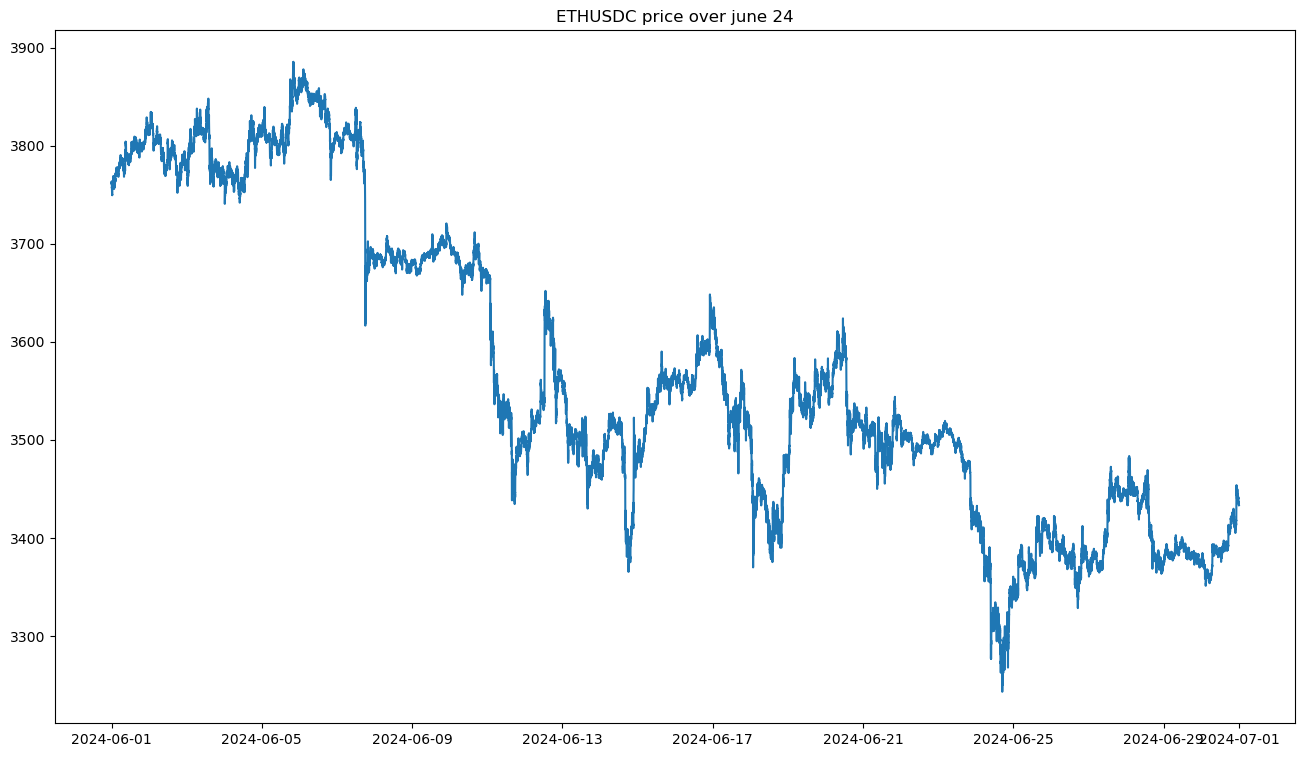

In [13]:
plt.plot(df_june.index.values, df_june['close'].values)
plt.title(pair+' price over june 24')
plt.show()

STANDARD GBM

In [14]:
df_june['log_returns'] = np.log(df_june['close'] / df_june['close'].shift(1))

trading_minutes_per_year = 365 * 24 * 60

log_return_mean = df_june['log_returns'].mean()

mu = log_return_mean * trading_minutes_per_year

log_return_variance = df_june['log_returns'].var()

vol = np.sqrt(log_return_variance * trading_minutes_per_year)

print('mu=',mu)
print('mu_daily=',mu/365)
print('sigma=',vol)
print('sigma_daily=',vol/np.sqrt(365))

mu= -1.1142161174650218
mu_daily= -0.0030526468971644434
sigma= 0.4563135551803073
sigma_daily= 0.02388454309835624


HESTON MODEL

In [15]:
window_size = 60  # 1 hour window
df_june['rolling_std'] = df_june['log_returns'].rolling(window=window_size).std()
df_june['annualized_volatility'] = df_june['rolling_std'] * np.sqrt(trading_minutes_per_year)

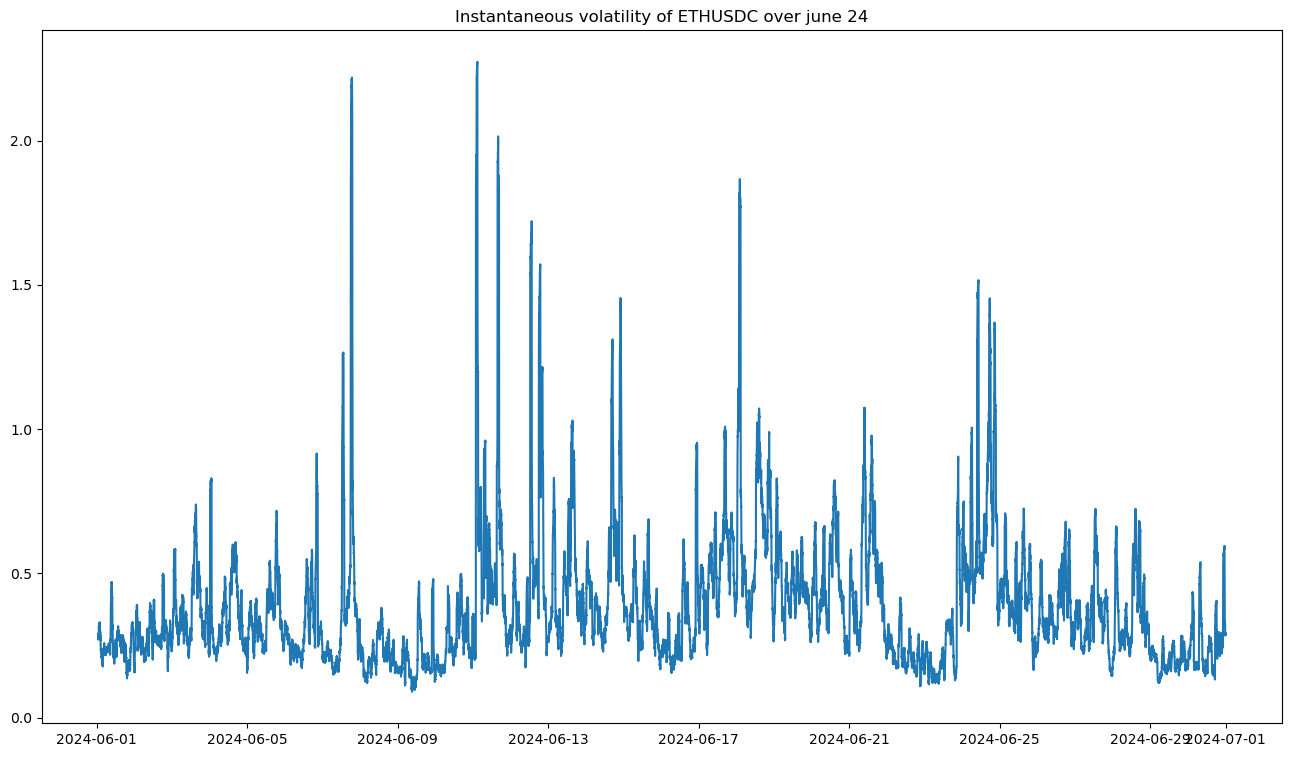

In [16]:
plt.plot(df_june.index.values, df_june['annualized_volatility'].values)
plt.title('Instantaneous volatility of '+pair+' over june 24')
plt.show()

In [17]:
initial_params = [1e-12, 1e-12, 0.02]

dt = 1./trading_minutes_per_year

variances = df_june['annualized_volatility']**2

result = minimize(heston_log_likelihood, initial_params, args=(variances, dt), method='Powell')

kappa_opt, theta_opt, sigma_opt = result.x

print(f"Estimated kappa: {kappa_opt}")
print(f"Estimated theta: {theta_opt}")
print(f"Estimated sigma: {sigma_opt}")

Estimated kappa: 2.587928961546842
Estimated theta: 2.587928961546842
Estimated sigma: 2.607928961545842


CALIBRATION ON DATA FROM JULY 24


In [ ]:
df_07 = pd.read_csv('../data/'+pair+'/'+pair+'-1m-2024-07.csv')
df_07.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_07.set_index('time', inplace=True)
df_07.index = pd.to_datetime(df_07.index, unit='ms')
df_07

,open,high,low,close,s1,s2,s3,s4,s5,s6,s7
time,,,,,,,,,,,
2024-07-01 00:01:00,3434.01,3434.65,3433.22,3433.22,0.6684,1719792119999,2295.282611,17,0.2880,988.983783,0
2024-07-01 00:02:00,3432.84,3432.84,3432.39,3432.39,0.0633,1719792179999,217.295581,9,0.0058,19.910472,0
2024-07-01 00:03:00,3432.40,3433.13,3431.82,3432.31,4.4912,1719792239999,15416.515842,28,1.8025,6186.961292,0
2024-07-01 00:04:00,3432.57,3432.57,3432.11,3432.11,0.9654,1719792299999,3313.417572,7,0.0000,0.000000,0
2024-07-01 00:05:00,3431.83,3434.59,3431.83,3434.05,5.1018,1719792359999,17513.068846,15,5.0946,17488.346590,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 23:55:00,3232.71,3233.49,3232.53,3233.40,1.8466,1722470159999,5970.039376,18,1.3908,4496.247664,0
2024-07-31 23:56:00,3233.49,3233.49,3232.71,3233.40,2.1609,1722470219999,6986.517355,17,0.8585,2775.628419,0
2024-07-31 23:57:00,3233.30,3233.71,3233.00,3233.40,1.6908,1722470279999,5466.900920,19,0.8020,2593.155000,0


In [19]:
df_july = df_07[['close']].copy()
df_july

,close
time,
2024-07-01 00:01:00,3433.22
2024-07-01 00:02:00,3432.39
2024-07-01 00:03:00,3432.31
2024-07-01 00:04:00,3432.11
2024-07-01 00:05:00,3434.05
...,...
2024-07-31 23:55:00,3233.40
2024-07-31 23:56:00,3233.40
2024-07-31 23:57:00,3233.40


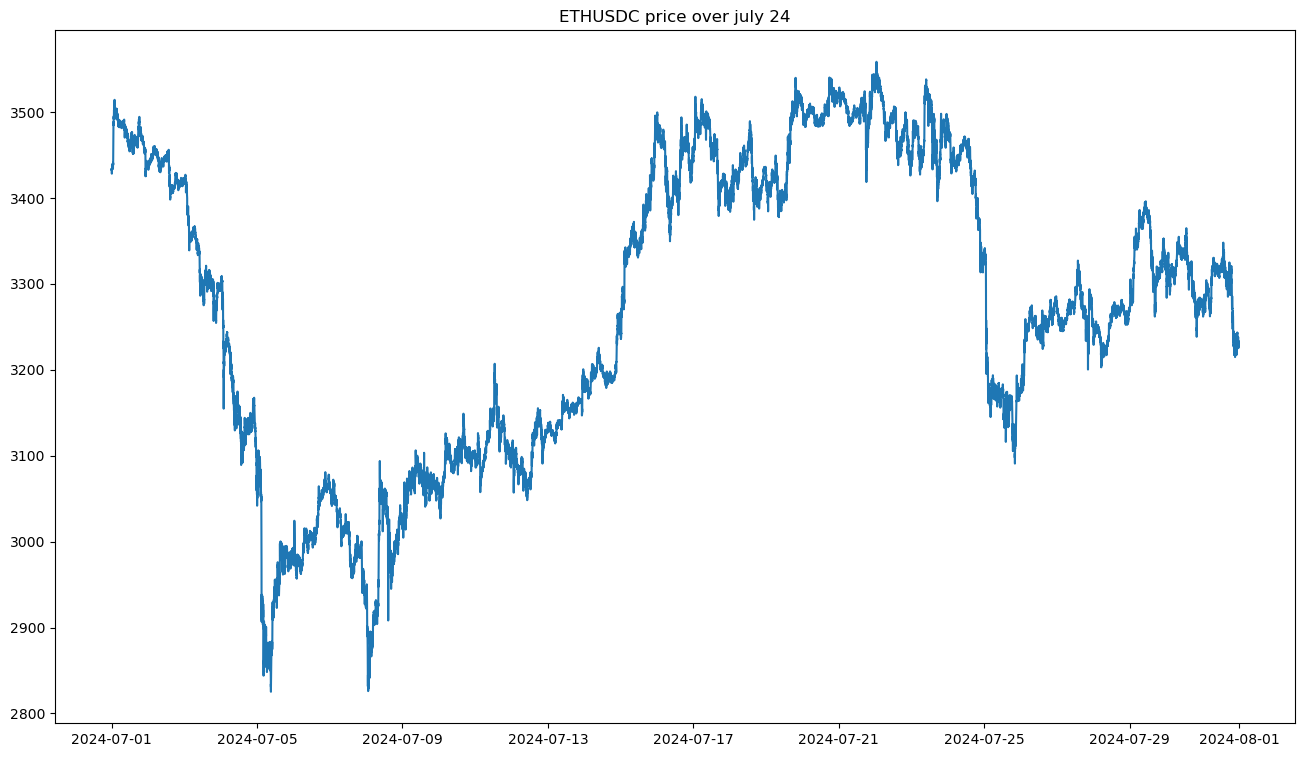

In [20]:
plt.plot(df_july.index.values, df_july['close'].values)
plt.title(pair+' price over july 24')
plt.show()

STANDARD GBM

In [21]:
df_july['log_returns'] = np.log(df_july['close'] / df_july['close'].shift(1))

trading_minutes_per_year = 365 * 24 * 60

log_return_mean = df_july['log_returns'].mean()

mu = log_return_mean * trading_minutes_per_year

log_return_variance = df_july['log_returns'].var()

vol = np.sqrt(log_return_variance * trading_minutes_per_year)

print('mu=',mu)
print('mu_daily=',mu/365)
print('sigma=',vol)
print('sigma_daily=',vol/np.sqrt(365))

mu= -0.7125841163701446
mu_daily= -0.0019522852503291634
sigma= 0.5841391998062597
sigma_daily= 0.030575243130130107
